# Makemore

```{contents}
:local:
```

I came in with 0 knowledge of NLP, came out of Andrej's video with a wealth of
understanding!

In [632]:
# from rich.jupyter import print
from rich.pretty import pprint
import torch
from typing import Literal, List, Dict, Any, Union, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

from common_utils.core.common import seed_all

1.35 - character level language model
- What is it? Given concrete example.

## Notations

Let's define our notations relevant to the bigram model:

- $\mathcal{V}$ is our vocabulary, which is the finite set of all possible
        characters. We denote each character as $v_i$ where $i$ ranges from $1$
        to $|\mathcal{V}|$ and $|\mathcal{V}|$ is the size of the vocabulary.
        And in our context, this is $27$ because it has $26$ letters and a
        special character `.`.
- $s = (s_1, s_2, ..., s_n)$
  - This is a sequence of characters which we treat as our data point
        $\mathbf{z}$. Each character $s_i$ takes a value from the set
        $\mathcal{V}$.
- $\boldsymbol{A} \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$
  - This is a matrix of parameters for our bigram model. Each element
        $A_{j, k}$ gives the conditional probability of character $v_k$
        following the character $v_j$, i.e.
        $A_{j, k} = \mathbb{P}(s_i = v_k | s_{i-1} = v_j; \Theta)$ where
        $\Theta$ is the set of all parameters of our model.
- $\boldsymbol{P}$ is the transition matrix of our bigram model. It is a
    matrix of conditional probabilities, where each row is a categorical
    distribution over the vocabulary $\mathcal{V}$. It is the same as the
    parameter matrix $\boldsymbol{A}$.
- Here, a sequence $s$ is actually the name, which is a word. And what we are
    finding is the **_joint probability_** of **_observing_** the word. In fact,
    we are finding the "best" parameters
    $\Theta = \boldsymbol{A} = \boldsymbol{P}$ that maximize the joint
    probability of observing the word. The joint probability is the product of
    the conditional probabilities of each character in the word, which is the
    product of the transition probabilities of each bigram in the word.
- $\mathcal{S}_{\mathrm{train}}$ represents the training set. In our context, the training set consists of the set of all words (names in our example) that we use to train our bigram model.
- A data point $\mathbf{s}^{(n)} \in \mathcal{S}_{\mathrm{train}}$ would be a
    single word or name. Remember that we treat each word (name) as a sequence
    of characters, and that is what a data point in our training set represents.
    For instance, if we have the names "John" and "Doe" in our training set,
    then each of these names is a separate data point in
    $\mathcal{S}_{\mathrm{train}}$. Each name can further be broken down into a
    sequence of characters, e.g., "John" becomes ("J", "o", "h", "n"). Our
    bigram model then estimates the conditional probabilities between these
    characters in a name (sequence).
- We can use $n$ as an index to represent individual data points, and use $i$
    as an index within each sequence. So, each data point would be represented
    as $\mathbf{s}^{(n)} = (s^{(n)}_1, s^{(n)}_2, ..., s^{(n)}_{|s^{(n)}|})$,
    where each $s^{(n)}_i$ is a character in the vocabulary $\mathcal{V}$, and
    $|s^{(n)}|$ is the length of the $n$-th sequence.

    This means that our training set $\mathcal{S}_{\mathrm{train}}$ consists of $N$
    sequences of characters,
    $\mathcal{S}_{\mathrm{train}} = \{\mathbf{s}^{(1)}, \mathbf{s}^{(2)}, ..., \mathbf{s}^{(N)}\}$,
    where $N$ is the number of sequences (or words/names in this case).


Unlike many standard machine learning problems, these sequences may not all have the same length, since words (names in this case) can have different numbers of characters. However, the total number of possible different characters (the size of the vocabulary $\mathcal{V}$) is the same for all sequences, and this is what constrains and defines the structure of our probability model.

In the context of the bigram model, the parameters we are optimizing (the entries in the matrix $\boldsymbol{A}$ or $\boldsymbol{P}$) reflect the conditional probabilities of transitioning from one character to another. These probabilities are learned from the sequences of characters in our training set $\mathcal{S}_{\mathrm{train}}$.


## Intuition

The application of the bigram model in the context of "makemore" falls under a
category of models known as generative models. Unlike discriminative models,
which learn the boundary between different classes, generative models learn the
distribution of the data, and can therefore generate new data that is similar to
the training data.

In the case of "makemore", the aim is to **generate** new names that are similar
in structure and feel to the names in the training data. This is achieved by
learning the bigram model from the training data, and then using this model to
generate new names.

## Loading the Data

The first few lines of the code load our dataset, which is a text file named
`names.txt`. This file is then read and split into separate lines, with each
line becoming an element in the list `words`. This is what the code looks like:

In [633]:
words = open('names.txt', 'r').read().splitlines()

Here, each line of the text file `names.txt` is assumed to be a unique name. For
example, the first three names might be 'emma', 'olivia', and 'ava'.

In [634]:
print(f"words: {words[:3]}")

words: ['emma', 'olivia', 'ava']


## Statistical Structure of a Word

Examining the word 'isabella', we can make certain observations about the
statistical structure of this name:

It's likely to begin with the letter 'i'. Following the letter 'i', it's
plausible to have an 's'. As we progress further, we see a sequence of other
characters. The name is likely to terminate with an 'a'. This leads us to
wonder: if we commence a word with 'i', what is the most probable subsequent
letter? Is it always 's'? Not necessarily. The whole idea here is that the
generative model in itself are probabilistic. So, we can't be certain about the
next letter as the next letter is sampled from a probability distribution.

One of the notable characteristics of GPT and similar models is that they're
probabilistic. This means they consider multiple possible next words and choose
one based on learned probabilities. This is why if you provide the same prompt
twice, you might receive two different responses: both are plausible
continuations, but the model may have assigned slightly different probabilities
each time.

This probability-driven behavior is what makes models like GPT versatile and
creative, capable of generating a wide array of responses to the same prompt.
Despite their complexity, they share the same fundamental principle with the
simple bigram model: predicting the next element in a sequence based on learned
patterns and probabilities.

## Analyzing the Data

Here, Andrej prints the length of the list of names, and the
minimum and maximum length of the names, providing a quick statistical overview
of the data.

In [635]:
# Print the length of the list
print(len(words))

# Print the minimum word length
print(min(len(w) for w in words))

# Print the maximum word length
print(max(len(w) for w in words))

32033
2
15


Print two consecutive letters

In [636]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a


## Dump

Why do we need to add `chs`?

In [637]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>'] # chs = characters
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


In [638]:
b = {}
for w in words[:3]:
    chs = ["<S>"] + list(w) + ["<E>"]  # chs = characters
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        # if bigram not in b, then b[bigram] = 0
        b[bigram] = b.get(bigram, 0) + 1

b

# 3  ('a', '<E>'): means that the letter 'a' is followed by the end of the word 3 times

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

In [639]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>'] # chs = characters
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    # if bigram not in b, then b[bigram] = 0
    b[bigram] = b.get(bigram, 0) + 1

1. Note the bigram here is bigram of letters, not words.

In [640]:
sorted(b.items(), key = lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [641]:
import torch
print(torch.__version__)

2.0.1


You want the array to be integer because bigram is holding info of counts.

In [642]:
a = torch.zeros((3, 5))
a.dtype

torch.float32

In [643]:
a = torch.zeros((3, 5), dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

## Deleting Spurious (S) and (E) tokens in Favor of (.) token

1. Watch video before 22 minute to understand why he used 28 by 28 initially, that's to correspond to `<S>` and `<E>`.
2. Now in the notebook it is 27 by 27 because we don't need `<S>` and `<E>` anymore. We just replace with `.`.
3. This works better because of ??

## Defining Variables and Constants

In this part of the code, we first set up our variables and constants. We define
`NUM_CHARS` as 27 which represents the total unique characters we'll consider,
including the 26 lowercase alphabets and a special character '.'.

In [644]:
NUM_CHARS = 27
DTYPE = torch.int32
SEED = 2147483647

# Create a 27x27 matrix of zeros
N = torch.zeros((NUM_CHARS, NUM_CHARS), dtype=DTYPE)

In [645]:
Alphabets = Literal[
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",
]

Specials = Literal["."] # Literal["<S>", "<E>"]

## Mapping Characters to Integers

We then create a set of alphabets and a special character which we'll use in our
mapping. We create two dictionaries for mapping characters to integers and
integers back to characters. The `stoi` dictionary is for string to integer
mapping, and the `itos` dictionary is for integer to string mapping. The special
character is mapped to 0 in `stoi` and the rest of the characters are mapped to
the subsequent numbers.

In [646]:
chars: List[Alphabets] = sorted(list(set("".join(words))))

# string to index/integer
stoi: Dict[Union[Alphabets, Specials], int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
print(stoi)

# index/integer to string
itos: Dict[int, Union[Alphabets, Specials]] = {i: s for s, i in stoi.items()}
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Creating the Bigram Model

The function `create_bigram_model` constructs a bigram model. It initializes a
2D tensor (or matrix) `N` with zeroes to store the bigram counts. Then, for each
word in the dataset, it appends a special character at the start and end of the
word and increments the count of each bigram in the matrix `N`.

In [647]:
def create_bigram_model(
    words: List[str], stoi: Dict[str, int], num_chars: int
) -> Union[torch.Tensor, List[List[Union[Alphabets, Specials]]]]:
    """
    Create a bigram model from a list of words.

    Parameters
    ----------
    words: A list of words to use to create the bigram model.
    stoi: A dictionary that maps each character to a unique index.
    num_chars: The number of unique characters.

    Returns
    -------
    A 2D tensor representing the bigram model.
    """
    # Initialize a 2D tensor to store the bigram counts
    N = torch.zeros((num_chars, num_chars), dtype=torch.int32)
    chs_list = []

    # Loop over each word in the dataset
    for w in words:
        # Convert the word into a list of characters, adding a '.' at the start and end
        chs = ["."] + list(w) + ["."]
        chs_list.append(chs)

        # Loop over each pair of consecutive characters in the word
        for ch1, ch2 in zip(chs, chs[1:]):
            # Convert the characters into their corresponding indices
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]

            # Increment the count of the bigram (ch1, ch2) in the matrix N
            N[ix1, ix2] += 1

    return N, chs_list

In [648]:
emma_olivia_ava = words[:3]
N, chs_list = create_bigram_model(emma_olivia_ava, stoi, NUM_CHARS)
print(chs_list)
print(N[0])

[['.', 'e', 'm', 'm', 'a', '.'], ['.', 'o', 'l', 'i', 'v', 'i', 'a', '.'], ['.', 'a', 'v', 'a', '.']]
tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=torch.int32)


In the context of a bigram model, each row of the matrix `N` represents the
counts of bigrams that start with a specific character.

More specifically, if `N` is a matrix representing a bigram model, then
`N[i, j]` is the count of the bigram `(ch_i, ch_j)`, where `ch_i` and `ch_j` are
characters and `i` and `j` are their corresponding indices.

So, each row `N[i, :]` represents the counts of bigrams that start with the
character `ch_i`. Each element in the row is the count of a bigram that starts
with `ch_i` and ends with another character.

For example, if we have a simple model with an alphabet of {a, b, c}, and 'a' is
mapped to index 0, 'b' to 1, and 'c' to 2, then the row `N[0, :]` would
represent the counts of bigrams that start with 'a'. So, `N[0, 0]` would be the
count of the bigram ('a', 'a'), `N[0, 1]` would be the count of the bigram ('a',
'b'), and `N[0, 2]` would be the count of the bigram ('a', 'c').

## Testing the Model

After creating the bigram model, the code tests it using a small set of words.
It asserts that the count of certain bigrams in the dataset matches the expected
count.

In [649]:
assert N[stoi["."], stoi["a"]] == 1 # this is <S>a == .a ==
assert N[stoi["a"], stoi["v"]] == 1 # this is a<v> == a.v ==

Out of the three words, we see that there is only one name that starts with the
letter `a`, so we can indeed assert that the count of the bigram `.a` is 1, which
is the case with `assert N[stoi['.'], stoi['a']] == 1`.

Similarly, we see there is only one count that starts with `a` and ends with `v`,
and we can assert that the count of the bigram `av` is 1, which is the case with
`assert N[stoi['a'], stoi['v']] == 1`.

## Plotting the Bigram Model

The `plot_bigram_model` function provides a visual representation of the bigram
counts as a heatmap. This visualization provides a clear and intuitive way to
understand the underlying patterns and relationships in the bigram model.

Basically it is plotting the $27 \times 27$ matrix `N` as a heatmap.

The function takes two parameters: `N`, a 2D tensor that represents the bigram
model, and `itos`, a list mapping each index to a unique character.

In this heatmap, the X and Y axes represent the indices of the characters. Each
cell in the grid corresponds to a pair of characters, and the color of the cell
corresponds to the frequency of that bigram in the dataset - the darker the
color, the higher the frequency.

In addition, the function also adds text to each cell to provide more detailed
information. The character pair (bigram) is placed at the bottom of the cell,
and the count of that bigram (the corresponding element from the `N` tensor) is
displayed at the top.

By examining this heatmap, one can quickly ascertain which bigrams are the most
common and see patterns in how characters tend to pair in the dataset.

In [650]:
def plot_bigram_model(N: torch.Tensor, itos: List[str]) -> None:
    """
    Plot a bigram model as a heatmap.

    Args:
    N: A 2D tensor representing the bigram model.
    itos: A list that maps each index to a unique character.

    Returns:
    None
    """
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap="Blues")
    for i in range(len(itos)):
        for j in range(len(itos)):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
    plt.axis("off")
    plt.show()

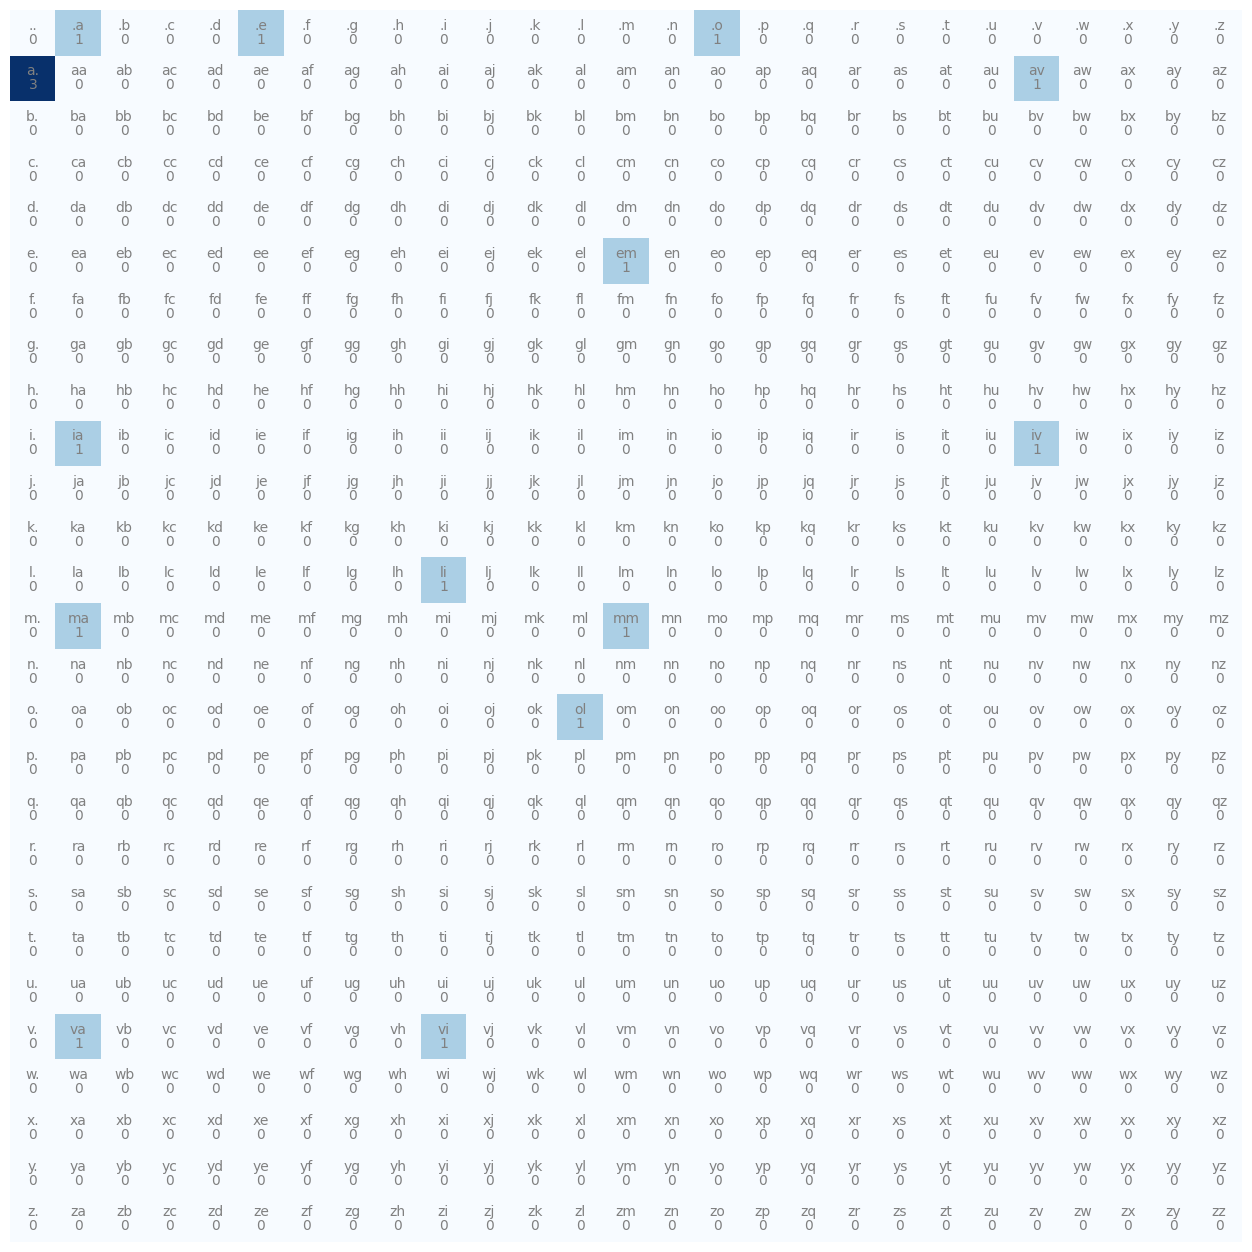

In [651]:
plot_bigram_model(N, itos)

## Sampling from a Bigram Model

To sample from the bigram model, the counts are normalized to get a probability
distribution for each character. The sampling process then takes place from this
distribution.

The first row of matrix `N` is normalized to form a probability distribution, as
demonstrated by Andrej Karpathy. Here's a line-by-line breakdown of the process:

1. `p = N[0].float()`: Selects the first row of `N` and converts it into a float
   tensor. The result is a tensor `p` containing the counts of bigrams starting
   with the character corresponding to index 0.

2. `p = p / p.sum()`: Each count in `p` is divided by the total sum of the
   counts. This operation normalizes the counts so that they total to 1,
   creating a probability distribution. After this line, `p` becomes a
   probability distribution over characters that can follow the character at
   index 0.

3. `assert p.sum() == 1.0`: A check to ensure that the probabilities in `p`
   total to 1, verifying that `p` is a valid probability distribution.

4. `print(p)`: Prints the probability distribution `p`.

In essence, this code generates a probability distribution over characters that
can follow the character at index 0, based on the counts in the bigram model
`N`. This is a typical step in generative AI models, as they often generate new
data based on probability distributions learned from the training data.

In [652]:
def normalize_counts(row_counts: torch.Tensor) -> torch.Tensor:
    """
    Normalize the counts in a tensor to form a probability distribution.

    Parameters
    ----------
    row_counts: A 1D tensor containing the counts of each bigram starting with
        a particular character.

    Returns
    -------
    A 1D tensor representing the probability distribution.
    """
    p = row_counts.float()
    p = p / p.sum()
    assert p.sum() == 1.0, "The probabilities do not sum to 1"
    return p

In [653]:
first_row = N[0, :]
p = normalize_counts(first_row)
print(p)
print(p.shape)

tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([27])


`N[0, :]` refers to the first row of the matrix `N`. Each element in this row
corresponds to the counts of a specific bigram. These bigrams are sequences of
two characters where the first character is the one mapped to index 0 (in this
case, `.`) and the second character is the one mapped to the index equal to the
column number.

Let's break down a few of these:

1. `N[0, 0]` is the count of the bigram `..`, i.e., the number of times `.`
   follows another `.` in our training dataset. As `.` is used to denote the
   start and end of a word, this count would typically be 0 as it's highly
   unlikely for a word to start or end with `.` in natural language.

2. `N[0, 1]` is the count of the bigram sequence `.a`, i.e., the number of times
   `a` is the first character of a word.

3. `N[0, 2]` is the count of the bigram sequence `.b`, i.e., the number of times
   `b` is the first character of a word.

4. The rest follows the same pattern.

Hence, each entry in this row tells us how many times a certain character
appears as the first character in a word in our dataset. After normalization, it
provides a probability distribution that describes the likelihood of each
character being the first character in a new word.

Consequently, the matrix row `N[0, :]` therefore captures the frequency of
occurrence of all possible characters that follow the `.` character in the
bigram. In the words `emma`, `olivia`, and `ava`, the characters `e`, `o`, and
`a` respectively follow the `.` character.

As per these names, the first characters are `e`, `o`, and `a`, so the
distribution will have approximately equal probabilities of $0.33$ for these
characters. This is because there are only $3$ names in the dataset, and each
name starts with a different character.

In [654]:
assert p[stoi["a"]] == 1/3
assert p[stoi["e"]] == 1/3
assert p[stoi["o"]] == 1/3

Continuing our exploration of matrix `N`, let's focus on the second row. This
row embodies the counts of bigrams whose first character is 'a'. If we normalize
this row, we transform these raw counts into a probability distribution,
signifying the likelihood of different characters following 'a'.

In other words, when normalized, the second row provides a probability 
distribution for the next character that could follow 'a' based on our data set of `["emma", "olivia", "ava"]`.

To put this into action, let's extract the second row from the `N` matrix and
apply normalization. This results in `p`, a probability distribution showcasing
possible characters that could succeed 'a' in our bigram model. These
probabilities provide key insights for our generative tasks. Here's the
corresponding code snippet.

In [655]:
second_row = N[1, :]
p = normalize_counts(second_row)
print(p)

tensor([0.7500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000])


Now the denominator here is $4$, this is because there are $3$ instances `a.`
where `a` is the end of a word, and there is $1$ instance of `av` where `v`
follows after `a`. This gives us a total of $4$ instances. We easily see that
the probability distribution is $0.75$ for `a.` and $0.25$ for `av`.

In [656]:
assert p[stoi["."]] == 3/4
assert p[stoi["v"]] == 1/4

## Conditional Probability

In essence, what we've been examining so far is the concept of a conditional
distribution, a fundamental component of probability theory. A conditional
distribution outlines a probability distribution over a specific subset or
sub-population of data. In this context, this subset consists of bigrams that
begin with a particular character.

For instance, when we normalize the first row of `N`, we're generating a
conditional distribution over possible characters that might follow the
character corresponding to the first index, say `.`. This is under the
assumption that the first character is indeed `.`.

Similarly, normalizing the second row of `N` establishes a conditional
distribution of possible characters following `a`, given the condition that the
first character is indeed `a`. This principle lies at the heart of bigram models
and other n-gram models. These models predict the next item in a sequence based
on the context of prior items.

This pattern applies to each row of `N`, where each row represents counts of
bigrams beginning with a specific character. When normalized, each row yields a
probability distribution over potential characters that could follow the
corresponding initial character.

This principle forms the backbone of bigram models and other types of n-gram
models, which predict the subsequent item in a sequence based on prior items or
contexts.

## MLE

We denote our sequence of characters as $s = (s_1, s_2, ..., s_n)$. Each
character $s_i$ takes a value from a finite set $V$, which represents our
vocabulary (i.e., the set of all possible characters).

Our bigram model parameterizes the joint probability of the sequence $s$ as a
product of conditional probabilities, with each character $s_i$ conditioned on
its predecessor $s_{i-1}$.

Mathematically, this can be written as:

$$
P(s; \Theta) = P(s_1; \Theta) \prod_{i=2}^{n} P(s_i | s_{i-1}; \Theta)
$$

Here, $\Theta$ denotes the set of all parameters of our model.

In the bigram model, the conditional probabilities $P(s_i | s_{i-1})$ are
modeled as categorical distributions over the set $V$, and these distributions
are parameterized by a matrix $A \in \mathbb{R}^{|V| \times |V|}$, where $|V|$
is the size of the vocabulary. Each element $A_{j, k}$ of this matrix gives the
probability of the character $v_k$ following the character $v_j$, where $v_k$
and $v_j$ are characters in the vocabulary $V$.

We can also represent $A_{j, k}$ as $P(s_i = v_k | s_{i-1} = v_j; \Theta)$ for
all $i = 2, ..., n$.

Thus, the likelihood of our sequence $s$ given the model parameters $\Theta$ is:

$$
L(\Theta; s) = P(s_1 = v_{j1}; \Theta) \prod_{i=2}^{n} P(s_i = v_{ki} | s_{i-1} = v_{ji}; \Theta)
$$

where each $v_{j1}$, $v_{ji}$, $v_{ki}$ is a character from $V$.

Taking the logarithm of both sides, we have the log-likelihood function:

$$
\log L(\Theta; s) = \log P(s_1 = v_{j1}; \Theta) + \sum_{i=2}^{n} \log P(s_i = v_{ki} | s_{i-1} = v_{ji}; \Theta)
$$

or, expressed in terms of the elements of the matrix $A$,

$$
\log L(\Theta; s) = \log A_{j1, j1} + \sum_{i=2}^{n} \log A_{ji, ki}
$$

This is the objective function we aim to maximize when training a bigram model.
The standard approach involves counting the frequency of each bigram in our
training data, and normalizing these counts to obtain the maximum likelihood
estimate of the matrix $A$. This approach applies when you have a fully observed
dataset. If some bigrams are missing from the training data, you might need to
apply smoothing techniques to ensure that every possible bigram has a non-zero
probability.


## What are we Modelling?

The parameters of the bigram model are the entries of the transition matrix $A$
or equivalently $P$. In other words, each parameter $A_{jk}$ represents the
conditional probability of observing character $v_k$ immediately following
character $v_j$, for all $j,k$ such that $1 \leq j, k \leq |\mathcal{V}|$.

So, our model parameters are these probabilities. The dimensionality of our
parameter space is $|\mathcal{V}| \times |\mathcal{V}|$, since we have a
probability for every possible pair of characters. This matrix of probabilities
is what we aim to learn from the data.

When we talk about "maximizing the likelihood of the data with respect to model
parameters," it means we are trying to find the set of parameters (i.e., the
transition matrix $A$ or $P$) that makes the observed data most probable under
the model. In other words, we want to adjust our model's parameters to best
explain the data we have.

Remember that, in our case, the "data" are the sequences of characters (or
words), and the "model" is the bigram model that predicts each character based
on the previous character. By adjusting the transition probabilities, we are
essentially learning how likely each character is to follow each other
character, based on the patterns we observe in the data.

The process of maximizing the likelihood is typically done iteratively, using
optimization algorithms such as gradient descent, which incrementally adjust the
parameters to increase the likelihood, or equivalently, to decrease the negative
log-likelihood. The negative log-likelihood is often used because it turns the
products of probabilities into sums of log-probabilities, which are more
numerically stable and easier to work with.

## The Joint Likelihood

Now, our model is assuming that the joint probability of the sequence $s$ is the
product of conditional probabilities, with each character $s_i$ conditioned on
its predecessor $s_{i-1}$. Using the notations defined above, the probability of
a sequence $s$ can be represented as:

$$
\mathbb{P}(s; \Theta) = \mathbb{P}(s_1; \Theta) \prod_{i=2}^{n} \mathbb{P}(s_i | s_{i-1}; \Theta)
$$

This is akin to the joint probability distribution
$\mathbb{P}(\mathcal{X}, \mathcal{Y}; \Theta)$ where $\mathcal{X}$ and
$\mathcal{Y}$ are the input and output spaces respectively, and $\Theta$ are the
parameters of the distribution. In our case, $\mathcal{X}$ is the previous
character in the sequence, $\mathcal{Y}$ is the current character, and $\Theta$
is the parameter matrix $\boldsymbol{A}$.

The likelihood of our sequence $s$ given the model parameters $\Theta$ is then:

$$
\mathcal{L}(\Theta; s) = \mathbb{P}(s_1 = v_{j1}; \Theta) \prod_{i=2}^{n} \mathbb{P}(s_i = v_{ki} | s_{i-1} = v_{ji}; \Theta)
$$

Taking the logarithm of the likelihood gives us the log-likelihood function:

$$
\log \mathcal{L}(\Theta; s) = \log \mathbb{P}(s_1 = v_{j1}; \Theta) + \sum_{i=2}^{n} \log \mathbb{P}(s_i = v_{ki} | s_{i-1} = v_{ji}; \Theta)
$$

or, expressed in terms of the elements of the matrix $\boldsymbol{A}$,

$$
\log \mathcal{L}(\Theta; s) = \log A_{j1, j1} + \sum_{i=2}^{n} \log A_{ji, ki}
$$

This log-likelihood is our objective function $\mathcal{L}(\Theta)$ which we aim
to maximize. The maximum likelihood estimation (MLE) for parameters $\Theta$ is
done by maximizing this objective function given our training dataset
$\mathcal{S}_{\mathrm{train}}$.

## s = (s1,s2,...) is our data point z or x? is there a label

In the context of unsupervised learning with the bigram model, the sequence
$s = (s_1, s_2, ..., s_n)$ serves as our data point and can be considered as
$\mathbf{x}$, where each $s_i$ corresponds to a character from the sequence.

For unsupervised learning tasks like this one, we don't have explicit labels
like in supervised learning. The "label" for each character $s_i$ is in fact the
next character in the sequence $s_{i+1}$, as the goal of the bigram model is to
predict the next character given the current one.

So in this context, each pair $(s_i, s_{i+1})$ can be thought of as an instance
of $(\mathbf{x}, \mathbf{y})$ in our data, where $\mathbf{x}=s_i$ is the input
and $\mathbf{y}=s_{i+1}$ is the "label" or target.

It's worth noting that the separation of data into $\mathbf{x}$ and $\mathbf{y}$
isn't quite as clear in unsupervised learning as it is in supervised learning.
In a bigram model, we are essentially shifting the same sequence one character
over to get our "labels". In this way, the sequence itself serves as both input
and target, depending on the context.

## so each word (name) is a data point and each character of the word is a?

Each word (name) can be treated as a data point, and each character in that word
can be treated as a feature, or more precisely, an observation in the sequence.

However, keep in mind that in a bigram model, we are not simply treating each
character as a standalone feature. Rather, we're considering the relationship
between each character and the character that immediately precedes it. So,
technically, each pair of successive characters, $(s_{i-1}, s_i)$, can be seen
as a single observational unit, forming the basis of our bigram model.

The distinction might be subtle, but it's an important one. Instead of looking
at each character in isolation, we're looking at how each character interacts
with the character before it, capturing the dependencies in our sequence data.

As such, the bigram model can be viewed as a specific case of a Markov model,
where the probability of each character depends only on the character that
immediately precedes it.


## Torch Multinomial

This snippet of code demonstrates how to use PyTorch's `torch.rand()` and
`torch.multinomial()` functions to sample from a discrete distribution.

1. `g = torch.Generator().manual_seed(SEED)`: This initializes a random number
   generator with a specified seed (`SEED`) to ensure reproducibility. This
   means that any operations in PyTorch that use this generator will produce the
   same sequence of random numbers every time the script is run.

2. `p = torch.rand(3, generator=g)`: This generates a 1D tensor of three random
   numbers drawn from a uniform distribution between 0 and 1. These numbers will
   be used as the weights or probabilities for a discrete distribution. The
   random numbers are generated using the generator `g`.

3. `p = p / p.sum()`: This normalizes the generated random numbers so that they
   sum up to 1. This is required to make `p` a valid probability distribution.

4. `torch.multinomial(p, num_samples=100, replacement=True, generator=g)`: This
   generates a tensor of 100 samples from the discrete distribution defined by
   `p`. Each sample is an index, and the probability of each index being drawn
   is given by the corresponding value in `p`. The `replacement=True` argument
   means that the same index can be chosen multiple times across different
   draws.

So, this code demonstrates how to define a discrete probability distribution in
PyTorch and how to draw samples from it. The distribution is defined by a tensor
of probabilities, and samples are drawn using `torch.multinomial()`. The random
number generator is initialized with a fixed seed to ensure that the same
sequence of random numbers (and hence the same sequence of samples) is produced
each time the code is run.

Here we define `N` again, but now we define it for all words in the dataset 
instead of just 3 words.

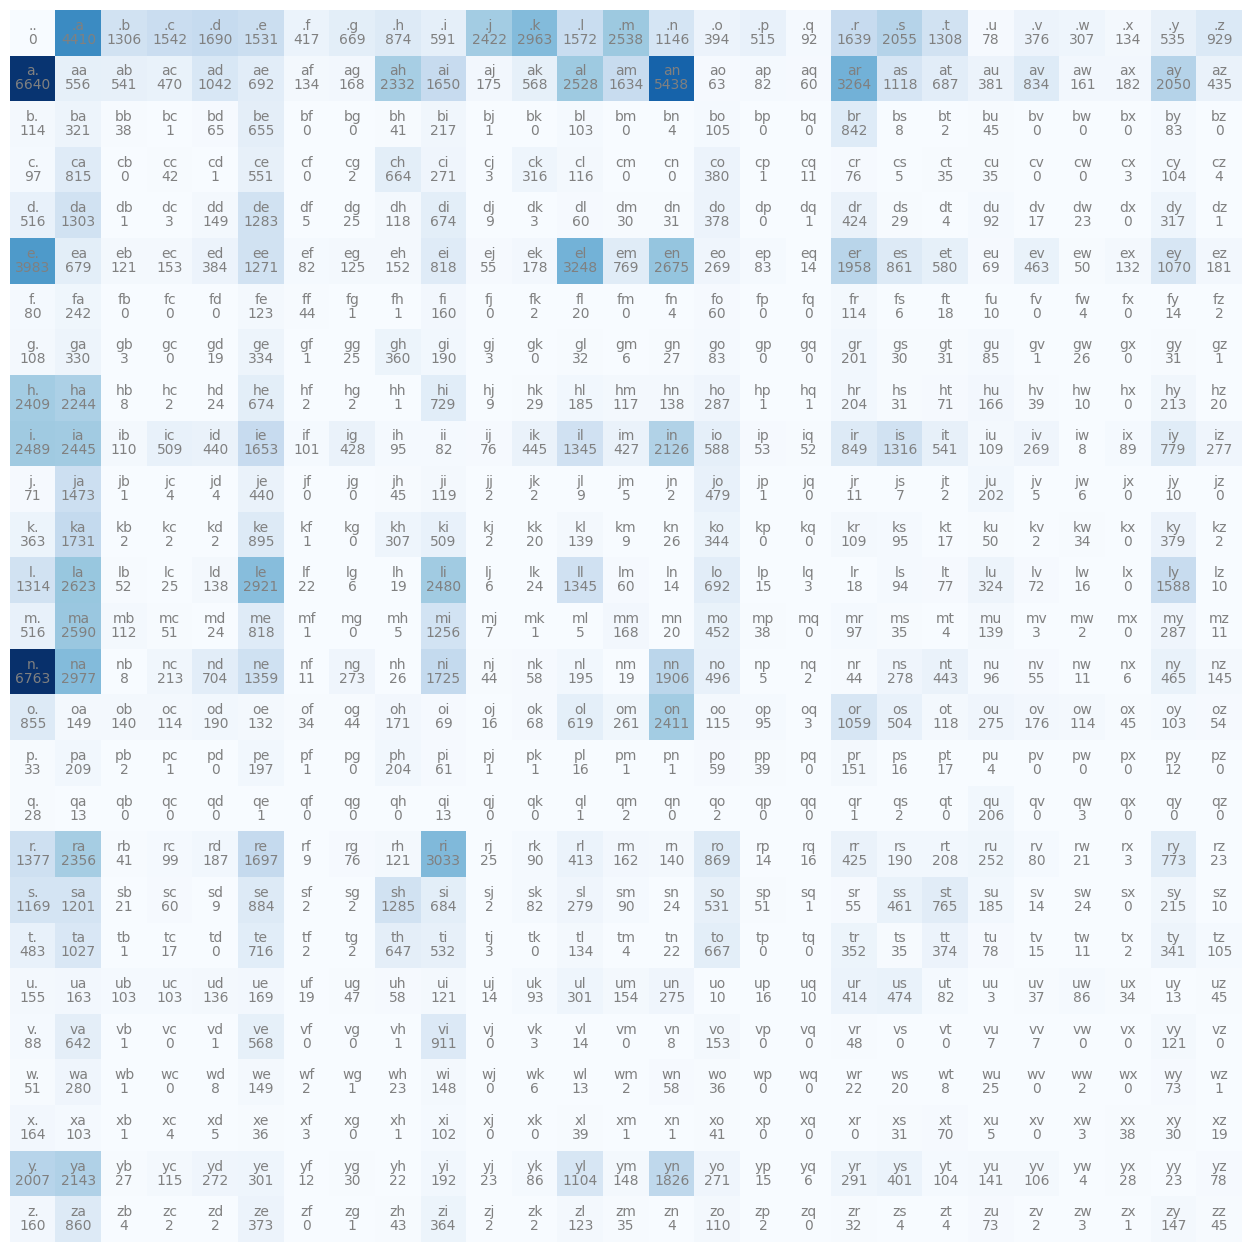

In [657]:
N, chs_list = create_bigram_model(words, stoi, NUM_CHARS)
plot_bigram_model(N, itos)

In [658]:
# g = torch.Generator().manual_seed(SEED)

p = N[0].float()
p = p / p.sum()
print(p)



tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


In [659]:
g = torch.Generator().manual_seed(SEED)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(f"ix = {ix}")

itos[ix]

ix = 3


'c'

these series of steps constitute a way to randomly sample a character from a given distribution. In the case of a bigram model, this distribution would be the probabilities of each character following a given character, and sampling from this distribution allows us to generate synthetic text that follows the patterns learned from the training data.

In [660]:
g: torch._C.Generator = torch.Generator().manual_seed(SEED)
# g_seed: int = g.seed()
# print(g_seed)

p = torch.rand(3, generator=g)
p = p / p.sum()
print(f"p = {p}")

samples = torch.multinomial(p, num_samples=100, replacement=True, generator=g)
print(f"samples\n\n{samples}")

p = tensor([0.6064, 0.3033, 0.0903])
samples

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])


But in the context of Bigram model, we do not want to sample $100$ samples from
the distribution. We want to sample only one sample from the distribution. 

So a common confusion is in the context of Trigram model, do we also sample only
$1$ or do we sample $2$ samples from the distribution? The answer is we sample
$1$ sample from the distribution.

Regardless of whether it's a bigram, trigram, or n-gram model,
`num_samples=1` is used because the `torch.multinomial` function is used to
sample one outcome (index) from the probability distribution defined by the
previous n-1 elements.

In other words, even in a trigram model, we are interested in predicting the
next token given the previous two tokens. So `num_samples` remains 1 because
we're still generating one token at a time.

The difference in a trigram model is in how the probabilities are calculated. In
a bigram model, the probability of each token is conditioned on the previous
token, whereas in a trigram model, the probability is conditioned on the
previous two tokens. But in both cases, we're still generating one token at a
time from the resulting probability distribution.


## Laplace Smoothing

Andrej did the following in his notebook by adding a small value, here is $1$,
to each element of the matrix $N$. Why?

In [661]:
P = (N+1).float()

This normalization step is for creating a valid probability distribution for
each character given the previous character, essentially calculating the
transition probabilities for the bigram model.

When we implement a bigram model, the matrix $P$ is used to store the transition
probabilities between characters. The value $P[i, j]$ corresponds to the
probability of transitioning from the $i$-th character in the vocabulary to the
$j$-th character.

Before this normalization step, $P$ contains the raw counts of each character
following another. In other words, $P[i, j]$ represents how many times the
$j$-th character appears after the $i$-th character in the training data.

However, to form a proper probability distribution for each character given the
previous character, we need to normalize these counts. The `.float()` method
converts the counts to floating point numbers, and `P.sum(1, keepdims=True)`
calculates the sum of the counts for each row (i.e., each $i$-th character).
Dividing $P$ by this sum then normalizes the counts so that the probabilities in
each row sum to $1$, forming a valid probability distribution.

The $N+1$ in the numerator is a smoothing operation to avoid zero probabilities.
This is necessary because if a character pair (bigram) did not occur in the
training data, its count would be zero, and therefore its probability would also
be zero. However, we don't want to completely rule out the possibility of seeing
this bigram in new data. By adding 1 to all counts ($N+1$), we assign a small
probability to all possible bigrams, even if they did not occur in the training
data. This is a variant of the add-one or Laplace smoothing technique.

In [662]:
assert P.shape == N.shape
assert N[stoi["."], stoi["."]] == 0
assert P[stoi["."], stoi["."]] == 1

Asserting does indeed confirm that we are just adding $1$ to each element of
the count matrix $N$ (okay I just asserted one but the idea is the same for all).

I conveniently asserted the first entry of the count matrix $N$ because we know
beforehand that the first entry of the count matrix $N$ is $0$ (i.e. because
`..` is not a valid bigram in the dataset). But the bigger idea is that there could
be valid bigrams that do not appear in the training dataset, for example, `pq` could
be a super rare bigram (who's name has `pq`) that does not appear in the training dataset. So we want
to ensure that we assign a small probability to all possible bigrams, even if
they did not occur in the training data. 

In [663]:
P = P / P.sum(dim=1, keepdim=True)
print(P[0])

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])


This line of code performs the row-wise normalization described above. It
ensures that for each row (i.e., for each character in the vocabulary), the sum
of the transition probabilities to all possible next characters equals 1. This
is a necessary condition for a valid probability distribution.


In [664]:
for row in P:
    assert torch.allclose(row.sum(), torch.tensor(1.0))

## Generating Sequences with the Bigram Model

In [665]:
from typing import List, Optional
import torch


def sample_next_character(p: torch.Tensor, generator: torch.Generator) -> int:
    # Sample next character index
    next_character = torch.multinomial(
        p, num_samples=1, replacement=True, generator=generator
    ).item()
    return next_character


def generate_sequences(
    num_sequences: int,
    P: torch.Tensor, # transition matrix
    itos: List[str],
    generator: Optional[torch.Generator] = None,
) -> List[str]:

    # If no generator is provided, create one with a default seed
    if generator is None:
        generator = torch.Generator().manual_seed(2147483647)

    # Initialize list to store all generated sequences
    all_sequences = []

    for _ in range(num_sequences):
        # Initialize list to store the current sequence
        sequence = []
        # Initialize current character to the start-of-sequence symbol (index 0)
        current_character = 0

        while True:
            p = P[current_character]
            # Sample next character index using the defined function
            current_character = sample_next_character(p, generator)
            # Add the character to the current sequence
            sequence.append(itos[current_character])

            # If the end-of-sequence symbol was sampled, break the loop
            if current_character == 0:
                break

        # Convert the list of characters to a string and add to the list of all sequences
        all_sequences.append("".join(sequence))

    return all_sequences


In [666]:
g = torch.Generator().manual_seed(SEED)
num_sequences = 5
transition_matrix = P

sequences = generate_sequences(num_sequences, transition_matrix, itos, g)
print(sequences)

['cexze.', 'momasurailezitynn.', 'konimittain.', 'llayn.', 'ka.']


This code generates a sequence of characters using the trained bigram model
stored in the transition matrix `P`. The idea is to start from a character, then
stochastically choose the next character based on the probabilities in `P`, and
continue this process to generate a sequence. Let's break down the process:

1. `g = torch.Generator().manual_seed(2147483647)`: This initializes a random
   number generator with a specific seed to ensure reproducibility. Any
   operations in PyTorch that use this generator will produce the same sequence
   of random numbers every time the script is run.

2. The `for` loop runs for 5 iterations, each iteration generating one character
   sequence.

3. `out = []`: Initializes an empty list to store the generated character
   sequence.

4. `ix = 0`: Initializes `ix` to 0. Here, `ix` is an index into the vocabulary
   representing the current character. The index 0 is usually associated with a
   special start-of-sequence symbol, indicating the beginning of a new sequence.

5. The inner `while` loop runs until it hits a condition that breaks it. This
   loop generates one character at a time. Absolutely. In practice, a common
   strategy is to use a specific character (or token) to represent the start and
   end of a sequence. Let's modify our toy example accordingly. Suppose our
   language now has five characters: '.', 'a', 'b', 'c', and the end-of-sequence
   character is still 'eos'. We'll use '.' to represent the start of a sequence.

Here's a revised hypothetical transition matrix `P`:

```
     .    a    b    c   eos
.   0.0  0.4  0.3  0.3  0.0
a   0.0  0.1  0.6  0.2  0.1
b   0.0  0.2  0.2  0.4  0.2
c   0.0  0.1  0.1  0.1  0.7
eos 0.0  0.0  0.0  0.0  1.0
```

Let's walk through the function for one sequence:

1. We start with the start-of-sequence character '.', so we fetch the transition
   probabilities for '.' from `P`, which are `[0.0, 0.4, 0.3, 0.3, 0.0]`.

2. We sample the next character index using these probabilities. Let's say the
   sample gives us 1, corresponding to 'a'.

3. We append 'a' to our sequence, which now becomes ['.', 'a'].

4. Now, we fetch the transition probabilities for 'a' from `P`, which are
   `[0.0, 0.1, 0.6, 0.2, 0.1]`.

5. We sample the next character index using these probabilities. Let's say the
   sample gives us 2, corresponding to 'b'.

6. We append 'b' to our sequence, which now becomes ['.', 'a', 'b'].

7. Now, we fetch the transition probabilities for 'b' from `P`, which are
   `[0.0, 0.2, 0.2, 0.4, 0.2]`.

8. We sample the next character index using these probabilities. Let's say the
   sample gives us 3, corresponding to 'c'.

9. We append 'c' to our sequence, which now becomes ['.', 'a', 'b', 'c'].

10. Now, we fetch the transition probabilities for 'c' from `P`, which are
    `[0.0, 0.1, 0.1, 0.1, 0.7]`.

11. We sample the next character index using these probabilities. Let's say the
    sample gives us 4, corresponding to 'eos'.

12. We append 'eos' to our sequence, which now becomes ['.', 'a', 'b', 'c',
    'eos'].

13. Since 'eos' is the end-of-sequence symbol, we stop here and return the
    sequence as a single string '.abc'.

The process is repeated for the desired number of sequences. For example, if
`num_sequences` is 5, we would generate 5 sequences like the one above. 6.
`p = P[ix]`: Fetches the transition probabilities for the current character.
These probabilities determine the likelihood of each other character appearing
next.

7. `ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()`:
   Chooses the next character index based on the transition probabilities `p`.
   The `torch.multinomial()` function takes a discrete probability distribution
   (given by `p`), and draws a sample from this distribution. The
   `num_samples=1` argument means that one sample is drawn (i.e., one character
   is chosen). The `replacement=True` argument means that the same character can
   be chosen multiple times across different draws. The `.item()` method
   extracts the value from the resulting one-element tensor.

8. `out.append(itos[ix])`: Converts the chosen character index back to the
   actual character using the `itos` (index-to-string) mapping, and adds the
   character to the output list `out`.

9. `if ix == 0: break`: If the chosen character index is 0 (which is usually
   associated with an end-of-sequence symbol), the loop breaks, indicating the
   end of the sequence.

10. Finally, `print("".join(out))` prints out the generated sequence of
    characters as a single string.

So, this code is generating and printing out 5 random sequences of characters,
where the probability of each character appearing after the previous one is
determined by the learned bigram model.

**The observant would have realized that there is no need to define the "start" character in the vocabulary. Why?**

This is because the start character is always the same, i.e., '.'. So, we can
always start with the index 0, and generate what follows, say if the next character
is `a`, then it just means the word starts with `a`. 

## Maximizing Negative Log-Likelihood

Let's denote our vocabulary by $\mathcal{V}$ and suppose it consists of
$|\mathcal{V}|$ unique characters (including the special start and end symbol
`.`). Our bigram language model defines a probability distribution over
sequences of characters, which we'll denote by $\mathbf{s}$.

For a given sequence of characters $\mathbf{s} = s_1, s_2, ..., s_N$ where each
$s_i$ is in $\mathcal{V}$, the bigram model gives us the joint probability of
the sequence as:

$$
\mathbb{P}(\mathbf{s}; \Theta) = \mathbb{P}(s_1; \Theta) \prod_{i=2}^{N} \mathbb{P}(s_i | s_{i-1}; \Theta)
$$

This is the chain rule of probability applied to the bigram assumption, which is
that the probability of a character only depends on the previous character.

The log likelihood of this sequence according to the bigram model is the log of
the above quantity, which due to properties of the log function, can be written
as a sum:

$$
\log \mathbb{P}(\mathbf{s}; \Theta) = \log \mathbb{P}(s_1; \Theta) + \sum_{i=2}^{N} \log \mathbb{P}(s_i | s_{i-1}; \Theta)
$$

In the provided code, `log_likelihood` is accumulating this sum over all bigrams
in the data. It's essentially computing the log likelihood of all the words in
our training data under the trained bigram model.

Therefore, if our training set is
$\mathcal{S}_{\mathrm{train}} = \{s_1, s_2, ..., s_N\}$ where each $s_i$
represents a word in the training set, then we can write the total log
likelihood as:

$$
\log \mathbb{P}(\mathcal{S}_{\mathrm{train}}; \Theta) = \sum_{i=1}^{N} \log \mathbb{P}(s_i; \Theta)
$$

where $\mathbb{P}(s_i; \Theta)$ is calculated using the bigram model as described above.

When `log_likelihood` is divided by `n` (the total number of bigrams), it gives
the average log likelihood per bigram. When negated, it becomes the average
negative log likelihood per bigram, which can be viewed as a per-bigram loss
measure of the bigram model's performance. This measure is then minimized during
the training process.

### To REVIEW

Let's denote our vocabulary by $\mathcal{V}$ and suppose it consists of $|\mathcal{V}|$ unique characters (including the special start and end symbol `.`). Our bigram language model defines a probability distribution over sequences of characters, which we'll denote by $\mathbf{s}$.

For a given sequence of characters $\mathbf{s}^{(n)} = (s^{(n)}_1, s^{(n)}_2, ..., s^{(n)}_{|s^{(n)}|})$ where each $s^{(n)}_i$ is in $\mathcal{V}$, the bigram model gives us the joint probability of the sequence as:

$$
\mathbb{P}(\mathbf{s}^{(n)}; \Theta) = \mathbb{P}(s^{(n)}_1; \Theta) \prod_{i=2}^{|s^{(n)}|} \mathbb{P}(s^{(n)}_i | s^{(n)}_{i-1}; \Theta)
$$

This is the chain rule of probability applied to the bigram assumption, which is that the probability of a character only depends on the previous character.

The log likelihood of this sequence according to the bigram model is the log of the above quantity, which due to properties of the log function, can be written as a sum:

$$
\log \mathbb{P}(\mathbf{s}^{(n)}; \Theta) = \log \mathbb{P}(s^{(n)}_1; \Theta) + \sum_{i=2}^{|s^{(n)}|} \log \mathbb{P}(s^{(n)}_i | s^{(n)}_{i-1}; \Theta)
$$

In the provided code, `log_likelihood` is accumulating this sum over all bigrams in the data. It's essentially computing the log likelihood of all the words in our training data under the trained bigram model.

Therefore, if our training set is $\mathcal{S}_{\mathrm{train}} = \{\mathbf{s}^{(1)}, \mathbf{s}^{(2)}, ..., \mathbf{s}^{(N)}\}$ where each $\mathbf{s}^{(n)}$ represents a word in the training set, then we can write the total log likelihood as:

$$
\log \mathbb{P}(\mathcal{S}_{\mathrm{train}}; \Theta) = \sum_{n=1}^{N} \log \mathbb{P}(\mathbf{s}^{(n)}; \Theta)
$$

where $\mathbb{P}(\mathbf{s}^{(n)}; \Theta)$ is calculated using the bigram model as described above.

When `log_likelihood` is divided by `n_{\mathrm{bigrams}}` (the total number of bigrams), it gives the average log likelihood per bigram. When negated, it becomes the average negative log likelihood per bigram, which can be viewed as a per-bigram loss measure of the bigram model's performance. This measure is then minimized during the training process.

### What are We Estimating?

In the bigram language model, we are estimating the conditional probabilities of observing each character given the previous character in a sequence. More specifically, we estimate parameters $\Theta$ which are all possible conditional probabilities $\mathbb{P}(s_j|s_i; \Theta)$ for all $s_i, s_j \in \mathcal{V}$, where $\mathcal{V}$ is the vocabulary of unique characters.

Why we do this has to do with the fundamental aim of the model. The objective of our model is to generate new sequences (e.g., names) that are similar to the ones in our training set. To achieve this, our model needs to learn the underlying patterns in the training data. In the context of the bigram model, these patterns are captured by the probabilities of character transitions - that is, given a character, what is the likelihood of each other character following it?

By learning to estimate these probabilities from the training data, the model can then generate new sequences that follow the same general patterns. It starts with the special start character, then repeatedly samples the next character based on the current one using the learned probabilities, until it samples the special end character. The sequence of characters sampled in this way forms a new name.

### Proof Character Level

Our bigram model is parametrized by $\Theta = \{ P(s_i | s_{i-1})\}_{s_i, s_{i-1} \in V}$, where $V$ is the vocabulary of all characters.

The likelihood of the data $S = (s_1, s_2, ..., s_N)$ given the parameters is given by:

$$
P(S | \Theta) = \prod_{i=1}^{N} P(s_i | s_{i-1}; \Theta)
$$

We typically work in the log domain for numerical stability and ease of computation, so the log-likelihood is:

$$
L(\Theta; S) = \log P(S | \Theta) = \sum_{i=1}^{N} \log P(s_i | s_{i-1}; \Theta)
$$

Our goal is to maximize $L(\Theta; S)$ with respect to $\Theta$. To do this, we must solve the following constrained optimization problem:

$$
\max_{\Theta} L(\Theta; S) \quad \text{subject to} \quad \sum_{s_i \in V} P(s_i | s_{i-1}; \Theta) = 1 \quad \text{for all} \quad s_{i-1} \in V
$$

The constraint ensures that each conditional probability distribution sums to 1.

We can solve this using the method of Lagrange multipliers. We construct the Lagrangian:

$$
\mathcal{L}(\Theta, \lambda) = L(\Theta; S) + \sum_{s_{i-1} \in V} \lambda_{s_{i-1}} \left(1 - \sum_{s_i \in V} P(s_i | s_{i-1}; \Theta)\right)
$$

Setting the derivative of $\mathcal{L}$ with respect to $P(s_i | s_{i-1}; \Theta)$ equal to zero gives:

$$
\frac{\partial \mathcal{L}}{\partial P(s_i | s_{i-1}; \Theta)} = \frac{1}{P(s_i | s_{i-1}; \Theta)} c_{s_{i-1}, s_i} - \lambda_{s_{i-1}} = 0
$$

where $c_{s_{i-1}, s_i}$ is the number of times the bigram $(s_{i-1}, s_i)$ appears in the sequence $S$. Rearranging terms gives:

$$
P(s_i | s_{i-1}; \Theta) = \frac{c_{s_{i-1}, s_i}}{\lambda_{s_{i-1}}}
$$

Setting the derivative of $\mathcal{L}$ with respect to $\lambda_{s_{i-1}}$ equal to zero gives the constraint:

$$
\frac{\partial \mathcal{L}}{\partial \lambda_{s_{i-1}}} = 1 - \sum_{s_i \in V} P(s_i | s_{i-1}; \Theta) = 1 - \frac{1}{\lambda_{s_{i-1}}} \sum_{s_i \in V} c_{s_{i-1}, s_i} = 0
$$

which implies that

$$
\lambda_{s_{i-1}} = \sum_{s_i \in V} c_{s_{i-1}, s_i}
$$

Substituting this into our equation for $P(s_i | s_{i-1}; \Theta)$ gives:

$$
P(s_i | s_{i-1}; \Theta) = \frac{c_{s_{i-1}, s_i}}{\sum_{s_i \in V} c_{s_{i-1}, s_i}}
$$

This gives us the maximum likelihood estimate for the bigram probabilities.

### Proof if word level

Here's the modified version for a word-level model:

We have a corpus of text represented as a sequence of words $W = (w_1, w_2, ..., w_N)$. Let's denote the set of all words (including the special start and end symbols) in the corpus by $V$.

The likelihood of the data $W = (w_1, w_2, ..., w_N)$ given the parameters $\Theta = \{ P(w_i | w_{i-1})\}_{w_i, w_{i-1} \in V}$ is given by:

$$
P(W | \Theta) = \prod_{i=1}^{N} P(w_i | w_{i-1}; \Theta)
$$

The log-likelihood is:

$$
L(\Theta; W) = \log P(W | \Theta) = \sum_{i=}^{N} \log P(w_i | w_{i-1}; \Theta)
$$

The task is to maximize $L(\Theta; W)$ with respect to $\Theta$, with the same constraint as before:

$$
\max_{\Theta} L(\Theta; W) \quad \text{subject to} \quad \sum_{w_i \in V} P(w_i | w_{i-1}; \Theta) = 1 \quad \text{for all} \quad w_{i-1} \in V
$$

The rest of the proof proceeds as before, substituting "word" for "character", and using the count of word bigrams $c_{w_{i-1}, w_i}$ instead of character bigrams.

## so we are computing the JOINT probability of each word

The code is computing the joint probability of each word by
multiplying the transition probabilities of its consecutive character pairs, or
in other words, its bigrams. The joint probability of a word (or character
sequence) under the bigram model is the product of the transition probabilities
for each bigram in the word.

This is based on the Markov assumption, which in this context is that the
probability of each character depends only on the previous character. That's why
we can calculate the joint probability of a word by simply multiplying the
transition probabilities of its bigrams.

The log likelihood is then computed as the sum of the logarithms of these joint
probabilities across all words in the data. This is equivalent to computing the
joint probability of the entire data under the bigram model, due to the property
that the log of a product is equal to the sum of logs.

The average negative log likelihood per bigram, computed at the end, can be
viewed as a loss measure indicating how well the bigram model predicts the data.
Lower values indicate better model performance.

## START OF MINUTE 50:14 ONWARDS

In [667]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

$P$ is our weight matrix now! Trained~

In [668]:
P = N.float()
P = P / P.sum(dim=1, keepdim=True)

In [669]:
log_likelihood = 0.0
n = 0

#for w in words:
for w in words:
    chs = ["."] + list(w) + ["."]
    # print(f"{chs=}")
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")


log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
2.454094171524048


To maximize the likelihood is equivalent to minimizing the negative log-likelihood. The reason we often use negative log-likelihood in practice is that the logarithm turns the products in the likelihood into sums, which are computationally easier to work with, and the negative sign converts a maximization problem into a minimization problem. Minimization problems are more standard in optimization theory and machine learning.

The negative log-likelihood (nll) is a common metric used to evaluate probabilistic models, such as our bigram model. It essentially measures how surprised the model is by the data; a lower nll means that the data is more likely under the model.



In [670]:
log_likelihood = 0.0
n = 0

#for w in words:
for w in ["andrejq"]:
    chs = ["."] + list(w) + ["."]
    print(f"{chs=}")
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")


chs=['.', 'a', 'n', 'd', 'r', 'e', 'j', 'q', '.']
.a: 0.1377 -1.9829
an: 0.1605 -1.8296
nd: 0.0384 -3.2594
dr: 0.0771 -2.5620
re: 0.1336 -2.0127
ej: 0.0027 -5.9171
jq: 0.0000 -inf
q.: 0.1029 -2.2736
log_likelihood=tensor(-inf)
nll=tensor(inf)
inf


What happened here? Let's say we split the dataset into train and validation, 
and somehow in validation we have the word `andrejq` and assuming the training
set has never seen the bigram `jq` before, then the probability of `jq` is $0$.
And $\log 0$ is undefined, giving rise to the `-inf` loss.

This did not happen previously can we evaluate on the whole training dataset, all of
which is seen at least once before.

This is where Laplace smoothing is applied!

In [671]:
P = (N+1).float()
P = P / P.sum(dim=1, keepdim=True)

log_likelihood = 0.0
n = 0

#for w in words:
for w in ["andrejq"]:
    chs = ["."] + list(w) + ["."]
    print(f"{chs=}")
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")


chs=['.', 'a', 'n', 'd', 'r', 'e', 'j', 'q', '.']
.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865


## PART II THE NEURAL NETWORK APPROACH

### Training Set Creation

#### Example on 1 Word

In [672]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)


. e
e m
m m
m a
a .


In [673]:
print(xs)
print(ys)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


#### Encoding

`xenc` = x encoded

In [674]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=NUM_CHARS).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Each row is a character.

In [675]:
xenc.shape

torch.Size([5, 27])

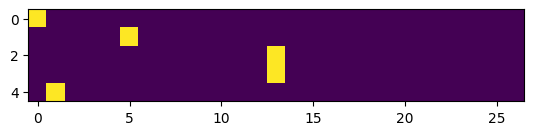

In [676]:
plt.imshow(xenc)

#### One Neuron

In [677]:
seed_all(SEED, seed_torch=True)

2147483647

In [678]:
W = torch.randn((NUM_CHARS, 1))
xenc @ W # (5, 27) @ (27, 1) = (5, 1)

tensor([[ 1.5674],
        [-0.0296],
        [ 0.0380],
        [ 0.0380],
        [-0.2373]])

In [679]:
W = torch.randn((NUM_CHARS, NUM_CHARS))
logits = xenc @ W # (5, 27) @ (27, 27) = (5, 27)
logits.shape

torch.Size([5, 27])

What's logits? Let's start by discussing the concept of "logits". In machine learning, the term "logits" refers to the vector of raw (non-normalized) predictions that a classification model generates, which are then passed to a normalization function (like the softmax function). If the model is designed to predict probabilities of different outcomes, then the logits are the logarithm of the odds of the outcomes, hence the name.

In [682]:
xenc[1][5]

tensor(1.)

In [680]:
logits[1, 13]

tensor(-0.2145)

In [631]:
logits[1, 13] == xenc[1] @ W[:, 13]

tensor(True)

In [681]:
W[:,13]

tensor([ 0.3801, -0.3056,  0.2072,  0.3175, -0.0558, -0.2145,  1.2348,  0.5205,
         0.8183, -0.6310, -1.4107,  0.6339, -0.0954, -0.0102,  0.0318,  0.1788,
        -0.2639,  0.2347,  0.5703, -2.3025, -1.8563,  1.3698, -0.3301,  1.2284,
        -0.7660,  0.1472, -0.5651])

In [686]:
xenc[1] @ W

tensor([ 1.8598,  0.6098, -0.2536, -0.6392, -0.7340,  2.0002, -0.3946,  0.0144,
         0.5722, -0.6954, -0.3695, -1.2707, -0.7319, -0.2145,  0.3271,  1.9661,
        -0.2409, -0.2544, -0.1217, -0.7924,  0.9805,  0.4113,  1.2648,  1.4625,
         1.1199, -0.5960, -1.4941])

In [685]:
logits[1] == xenc[1] @ W

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])

`logits[1, 13]` is `xenc[1] @ W[:, 13]`

Assume index starts from `0`.

- `xenc[1]` is the 2nd row of `xenc`, which is the 2nd character of the word which is `e` in `emma`
- Note in particular that `xenc[1]` is 1 at the 5th index and 0 elsewhere since it is `e`.
- `W[:, 13]` is the 14th column of `W`, which is the 14th neuron.
    - Which is the 14th neuron in the hidden layer.
    - represents the weights of connections from all input units to the 14th output unit in the network.
- So this matmul gives us a weighted sum of the 2nd character of the word with the 14th neuron in the hidden layer.
    - Note it is `-0.2145` which is just the 5th element in `W[:, 13]` because
     `xenc[1]` is just a one-hot vector with `1` at the 5th index and `0` everywhere else.
- The matrix multiplication `xenc[1] @ W[:, 13]` computes the dot product of the one-hot encoded vector for `'e'` and the weights for the 14th output unit which is 


In [621]:
W[:, 13]

tensor([ 0.3801, -0.3056,  0.2072,  0.3175, -0.0558, -0.2145,  1.2348,  0.5205,
         0.8183, -0.6310, -1.4107,  0.6339, -0.0954, -0.0102,  0.0318,  0.1788,
        -0.2639,  0.2347,  0.5703, -2.3025, -1.8563,  1.3698, -0.3301,  1.2284,
        -0.7660,  0.1472, -0.5651])

In [629]:
xenc[1]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [623]:
logits[3, 13]

tensor(-0.0102)

In [624]:
xenc[3] @ W[:, 13] == logits[3, 13]

tensor(True)

In [628]:
values, indices = logits[3].topk(3)
print(values)
print(indices)

print(itos[indices[0].item()])
print(itos[indices[1].item()])
print(itos[indices[2].item()])

tensor([1.7206, 1.2331, 1.2307])
tensor([ 0, 22,  7])
.
v
g


#### More Intuition



Now, when we're dealing with a character-level prediction model as in this case, each index in our logits vector corresponds to a prediction of the next character in the sequence.

Let's unpack `logits[3, 13]`:

- **`logits[3, 13]` corresponds to the raw prediction score that the model assigned to the possibility that the next character, after seeing the 4th character in the sequence (the 2nd 'm' in 'emma'), will be the character corresponding to the 13th index in our character set (whatever character that might be). Of course we do know it is `n` since
`chars[13]` is `n`. And we got `-0.0102` indicating unlikely, which is true since
not much word have `mn`.**
  
- **So, if the character in the 13th index of our character set was 'n', then `logits[3, 13]` would represent the raw score of how likely the model thinks 'n' is the next character after 'm'.**
  
- **The higher the value of `logits[3, 13]`, the more strongly the model predicts that the 13th character in our set will follow 'm'.**

It's crucial to remember that these scores are "raw". They do not represent probabilities and can be any real number, not just between 0 and 1. To convert them into probabilities, they should be passed through a softmax function, which will ensure that they sum to 1 and each lies in the range [0,1].


In [520]:
logits[3][13]

tensor(-0.0102)

In [521]:
logits[3][1]

tensor(-0.1636)

In [524]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [522]:
values, indices = logits[3].topk(3)
print(values)
print(indices)

print(chars[indices[0]])
print(chars[indices[1]])
print(chars[indices[2]])

tensor([1.7206, 1.2331, 1.2307])
tensor([ 0, 22,  7])
a
w
h


In [85]:
W

tensor([[ 0.3726],
        [-0.1670],
        [ 0.4067],
        [ 0.0337],
        [ 0.8887],
        [-1.1676],
        [-1.2554],
        [-2.0436],
        [-1.9493],
        [ 1.2490],
        [ 1.2263],
        [-0.8260],
        [-0.5349],
        [-0.3034],
        [-0.2479],
        [-0.5665],
        [ 0.2322],
        [ 0.3481],
        [ 0.4327],
        [ 0.3333],
        [-0.3456],
        [ 0.8424],
        [ 0.8349],
        [-1.0565],
        [-1.3681],
        [-1.7458],
        [-0.8351]])

In [46]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [47]:
probs[0]

tensor([1.])

In [48]:
probs[0].shape

torch.Size([1])

In [49]:
probs[0].sum()

tensor(1.)

In [50]:
# (5, 27) @ (27, 27) -> (5, 27)

In [51]:
# SUMMARY ------------------------------>>>>

In [52]:
xs

tensor([ 0,  5, 13, 13,  1])

In [53]:
ys

tensor([ 5, 13, 13,  1,  0])

In [54]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g)

In [55]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [56]:
probs.shape

torch.Size([5, 27])

In [57]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item()  # input character index
    y = ys[i].item()  # label character index
    print("--------")
    print(f"bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})")
    print("input to the neural net:", x)
    print("output probabilities from the neural net:", probs[i])
    print("label (actual next character):", y)
    p = probs[i, y]
    print("probability assigned by the net to the the correct character:", p.item())
    logp = torch.log(p)
    print("log likelihood:", logp.item())
    nll = -logp
    print("negative log likelihood:", nll.item())
    nlls[i] = nll

print("=========")
print("average negative log likelihood, i.e. loss =", nlls.mean().item())


--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

In [58]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [59]:
xs

tensor([ 0,  5, 13, 13,  1])

In [60]:
ys

tensor([ 5, 13, 13,  1,  0])

In [61]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [62]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [63]:
print(loss.item())

3.7693049907684326


In [64]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [65]:
W.data += -0.1 * W.grad

In [66]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [67]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [68]:
# gradient descent
for k in range(1):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

3.768618583679199


In [69]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(SEED)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

texzmkloglquszipczktxhkmpmzistttwinmlgdukzka.
zr.
rocxtpucjwtsc.
gmtokmxczisqytxugkwpt.
dajkkluydjmscdgu.


Exercises:
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?
E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
E06: meta-exercise! Think of a fun/interesting exercise and complete it.


## References and Further Readings

- https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf
- Chapter 3 of Jurafsky and Martin's Speech and Language Processing (3rd ed.)
- https://d2l.ai/chapter_recurrent-neural-networks/language-model.html [IMPORTANT]